# Transfer Learning Using Fine-Tuning of models

From [LearnOpenCV](https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/) blog post

All [LearnOpenCV Code](https://github.com/spmallick/learnopencv/blob/master/README.md) on github.

[Description](https://cs231n.github.io/transfer-learning/) of the different types of transfer learning.

* Transfer Learning (feature extraction )

In Feature Extraction Transfer Learning, we are removing the fully connected layer(s).  We do **not** retrain the weights in the convolutional layer, and the model will only be used to predict.  There is no `compile` nor `fit` step.  The output of the convolutional layer will be flattened into a vector, called CNN Codes, and this vector can be used with a linear model or custom fully connected layer for to classify the specific images.

This technique provides a very fast way to use an existing trained model, for new targets.

* Fine Tuning

In Fine Tuning, we are removing the fully connected layer(s) - but this time we **are** freezing the convolutional layer weights ( or some at least most of them ), retraining the weights of the new classification layers.  The new classification layers are typically a new fully connected layer/



In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import vgg16

from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Sequential, optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

import random
import os

%matplotlib inline

In [3]:
# settings for reproducibility
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

is_use_gpu = False
if is_use_gpu:
    gpu_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
    os.environ['TF_USE_CUDNN'] = '1'
else:
    os.environ["CUDA_VISIBLE_DEVICES"] ="-1"

Define locations of the train and validation datasets:

In [4]:
# each folder contains three subfolders in accordance with the number of classes
train_dir = './clean-dataset/train'
validation_dir = './clean-dataset/validation'

image_size = 224

## Experiment 1: Freezing all layers - Same as Transfer Learning

<h3>1. Freezing all layers</h3>

Create the model setting ``include_top`` parameter to ``False`` in order to exclude the fully-connected layers at the top of the network.

In [5]:
# Init the VGG model 
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x147d838b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x147e6cc40> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x147eab1f0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x147e6cd60> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x147ee21f0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x147ee2a90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x147eab4f0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x147efcbe0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x147f03e50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x147f0c2e0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x147f0cf40> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x147f11ca0> False
<tensorflow.py

<h3>2. Prepare the training and validation data</h3>

In [6]:
# Load the normalized images
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10

# Data generator for training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data generator for validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


<h3>3. Visualizing the datasets</h3>

In [7]:
# Utility function for quick class name access
def get_class_name(generator, image_id):
    # Get the image class and map its index with the names of the classes
    image_label_id = np.argmax(generator[image_id][1][0])
    classes_list = list(generator.class_indices.keys())
    return classes_list[image_label_id]

The shape of train images: (224, 224, 3)
The shape of validation images: (224, 224, 3)


Text(0.5, 1.0, 'Validation class name: tomato')

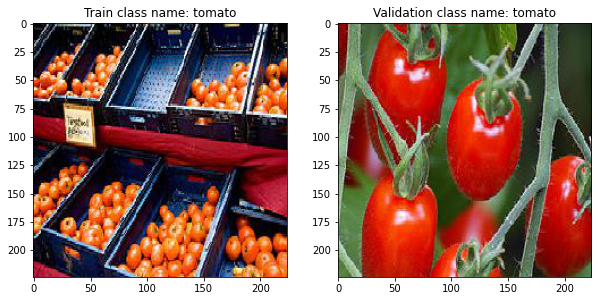

In [8]:
# Choose the image index for the visualization
image_id = 5

# Get the train image shape 
print("The shape of train images: {}".format(train_generator[image_id][0][0].shape))

# Get the validation image shape 
print("The shape of validation images: {}".format(validation_generator[image_id][0][0].shape))

# Visualize the train image example
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.imshow(train_generator[image_id][0][0])

# Show the train image class
plt.title("Train class name: {}".format(get_class_name(train_generator, image_id)))

# Visualize the validation image example
plt.subplot(122)
plt.imshow(validation_generator[image_id][0][0])

# show image class
plt.title("Validation class name: {}".format(get_class_name(validation_generator, image_id)))

<h3>4. Train the model</h3>

In [9]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

Epoch 1/20
6/6 [==============================] - 59s 10s/step - loss: 3.6052 - acc: 0.4367 - val_loss: 0.6374 - val_acc: 0.7133
Epoch 2/20
6/6 [==============================] - 59s 10s/step - loss: 0.7339 - acc: 0.7150 - val_loss: 0.4329 - val_acc: 0.8533
Epoch 3/20
6/6 [==============================] - 59s 10s/step - loss: 0.4897 - acc: 0.8217 - val_loss: 0.4606 - val_acc: 0.8200
Epoch 4/20
6/6 [==============================] - 58s 10s/step - loss: 0.2791 - acc: 0.8867 - val_loss: 0.5823 - val_acc: 0.8067
Epoch 5/20
6/6 [==============================] - 59s 10s/step - loss: 0.5772 - acc: 0.7900 - val_loss: 0.4804 - val_acc: 0.8067
Epoch 6/20
6/6 [==============================] - 59s 10s/step - loss: 0.1814 - acc: 0.9483 - val_loss: 0.3097 - val_acc: 0.8867
Epoch 7/20
6/6 [==============================] - 59s 10s/step - loss: 0.1430 - acc: 0.9550 - val_loss: 1.1773 - val_acc: 0.6067
Epoch 8/20
6/6 [==============================] - 59s 10s/step - loss: 0.3439 - acc: 0.8817 - val

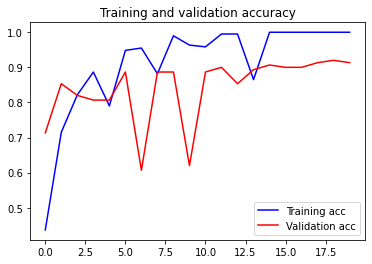

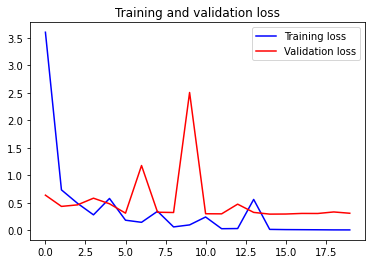

In [10]:
# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the model
model.save('all_freezed.h5')

# Run the function to illustrate accuracy and loss
visualize_results(history)

<h3>5. Show the errors</h3>

Let's define a couple of utility functions to avoid a code duplication in further experiments.

In [11]:
# Utility function for obtaining of the errors 
def obtain_errors(val_generator, predictions):
    # Get the filenames from the generator
    fnames = validation_generator.filenames

    # Get the ground truth from generator
    ground_truth = validation_generator.classes

    # Get the dictionary of classes
    label2index = validation_generator.class_indices

    # Obtain the list of the classes
    idx2label = list(label2index.keys())
    print("The list of classes: ", idx2label)

    # Get the class index
    predicted_classes = np.argmax(predictions, axis=1)

    errors = np.where(predicted_classes != ground_truth)[0]
    print("Number of errors = {}/{}".format(len(errors),validation_generator.samples))
    
    return idx2label, errors, fnames

In [12]:
# Utility function for visualization of the errors
def show_errors(idx2label, errors, predictions, fnames):
    # Show the errors
    for i in range(len(errors)):
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = idx2label[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[errors[i]].split('/')[0],
            pred_label,
            predictions[errors[i]][pred_class])

        original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
        plt.figure(figsize=[7,7])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()

15/15 [==============================] - 12s 771ms/step
The list of classes:  ['pumpkin', 'tomato', 'watermelon']
Number of errors = 13/150


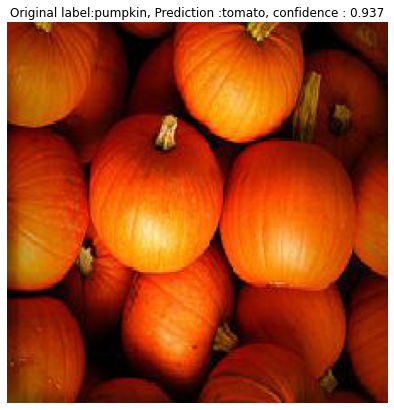

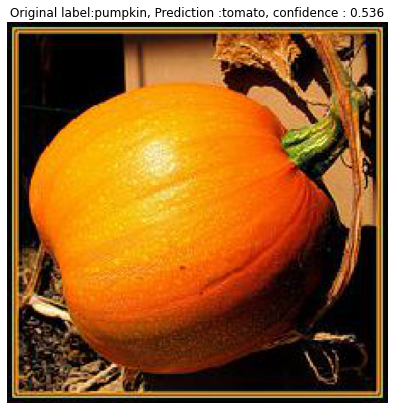

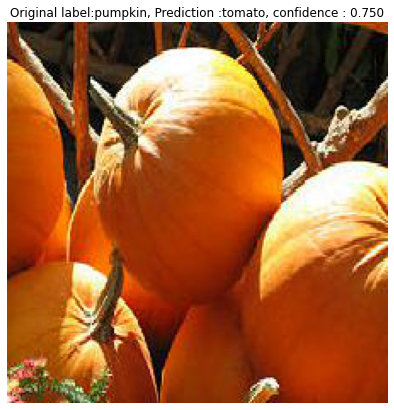

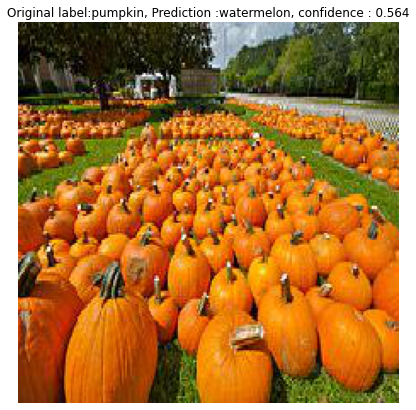

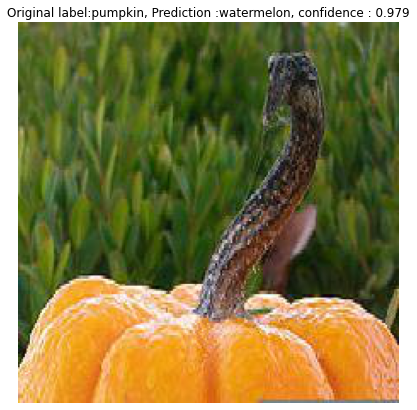

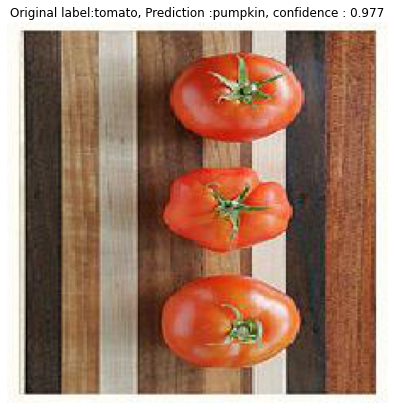

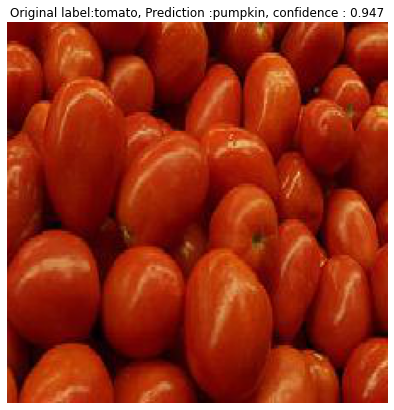

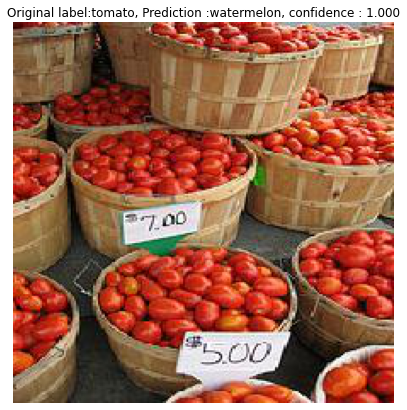

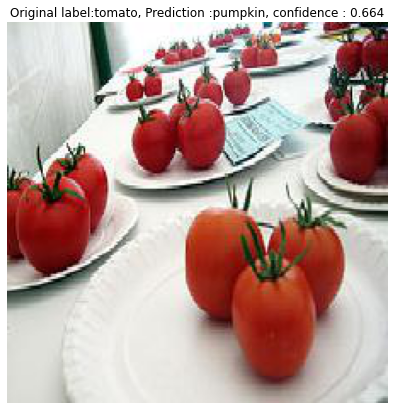

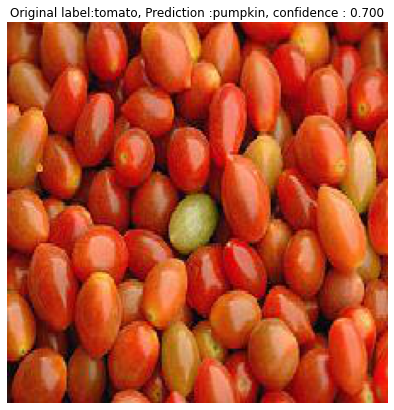

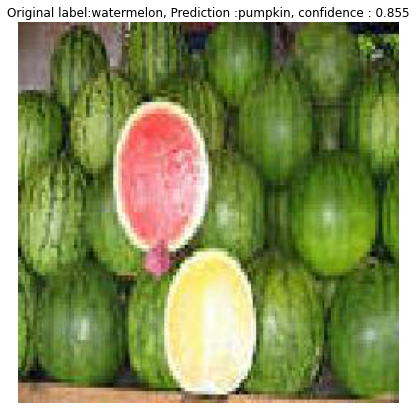

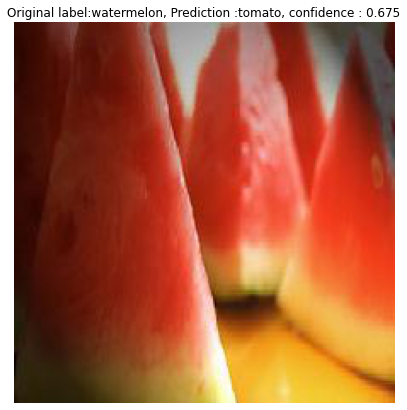

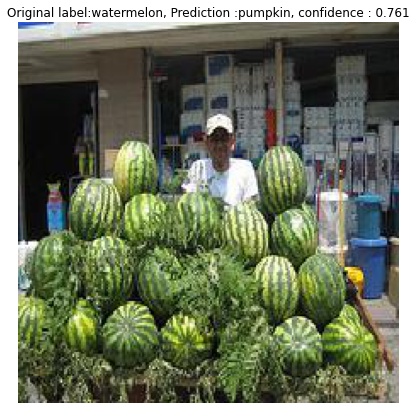

In [13]:
# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)

# Run the function to get the list of classes and errors
idx2label, errors, fnames = obtain_errors(validation_generator, predictions)

# Run the function to illustrate the error cases
show_errors(idx2label, errors, predictions, fnames)

## Experiment 2: Train Last 4 layers without data augmentation

<h3>1. Freezing all layers</h3>

Create the model setting include_top parameter to False in order to exclude the fully-connected layers at the top of the network.

In [14]:
#Load the VGG model
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x149077700> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x149077b20> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x148b31910> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x14810f160> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x149081df0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1490893d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x149089cd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x149093880> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x14909a1f0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x14909aac0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x149089d00> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1490a7490> False
<tensorflow.py

<h3>2. Prepare the training and validation data</h3>

In [15]:
# No data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10

# Data generator for training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data generator for validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


<h3>3. Train the last 4 layers without data augmentation</h3>

Epoch 1/20
6/6 [==============================] - 66s 11s/step - loss: 2.6022 - acc: 0.3617 - val_loss: 1.0533 - val_acc: 0.4600
Epoch 2/20
6/6 [==============================] - 68s 11s/step - loss: 1.1281 - acc: 0.5050 - val_loss: 0.8596 - val_acc: 0.6267
Epoch 3/20
6/6 [==============================] - 68s 11s/step - loss: 0.8327 - acc: 0.6117 - val_loss: 0.6412 - val_acc: 0.6933
Epoch 4/20
6/6 [==============================] - 68s 11s/step - loss: 0.4966 - acc: 0.7967 - val_loss: 0.2686 - val_acc: 0.9400
Epoch 5/20
6/6 [==============================] - 68s 11s/step - loss: 0.1745 - acc: 0.9500 - val_loss: 0.6003 - val_acc: 0.8133
Epoch 6/20
6/6 [==============================] - 68s 11s/step - loss: 0.6107 - acc: 0.7867 - val_loss: 0.2684 - val_acc: 0.8933
Epoch 7/20
6/6 [==============================] - 68s 11s/step - loss: 0.1085 - acc: 0.9633 - val_loss: 0.4250 - val_acc: 0.8733
Epoch 8/20
6/6 [==============================] - 68s 11s/step - loss: 0.0775 - acc: 0.9733 - val

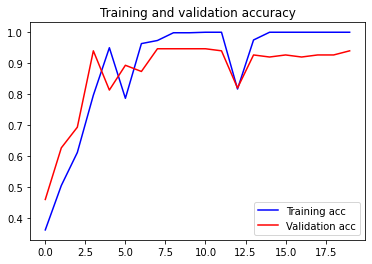

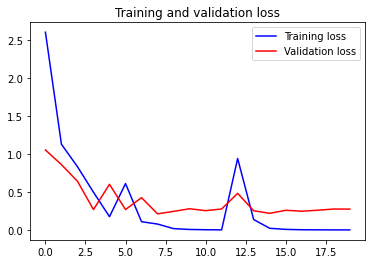

In [16]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the model
model.save('last4_layers.h5')

# Run the function to illustrate accuracy and loss
visualize_results(history)

<h3>4. Show the errors</h3>

15/15 [==============================] - 12s 822ms/step
The list of classes:  ['pumpkin', 'tomato', 'watermelon']
Number of errors = 9/150


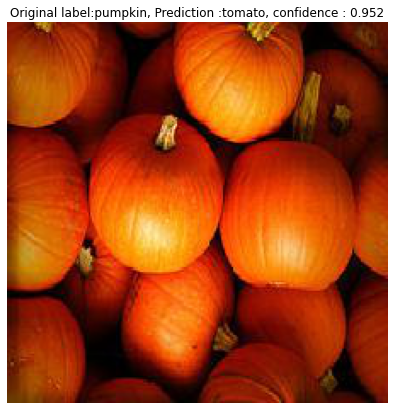

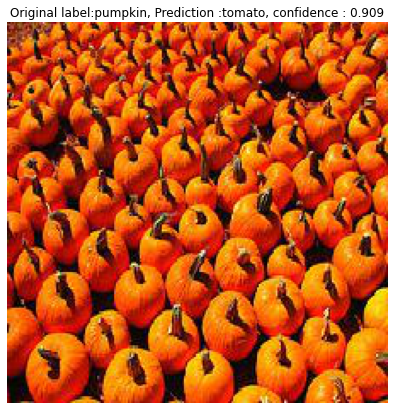

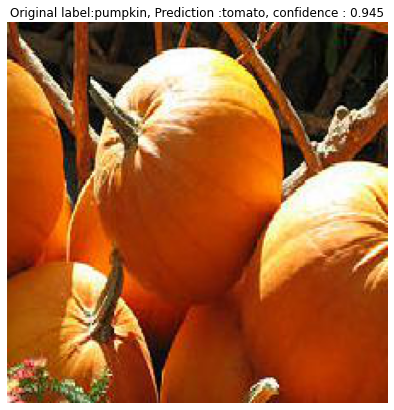

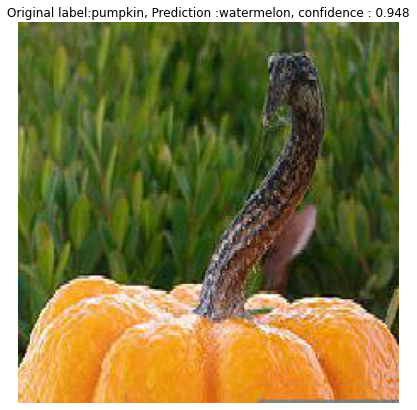

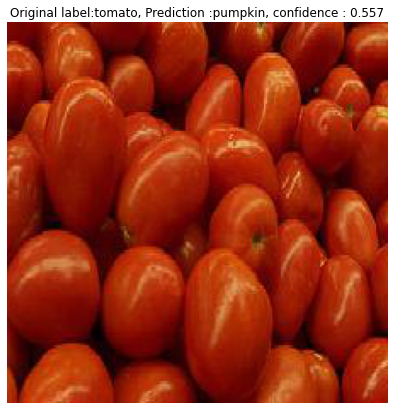

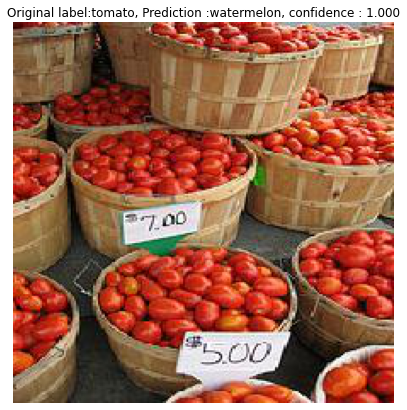

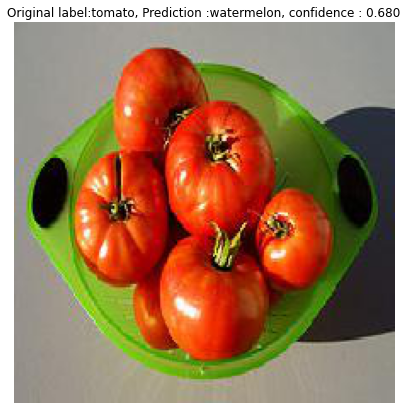

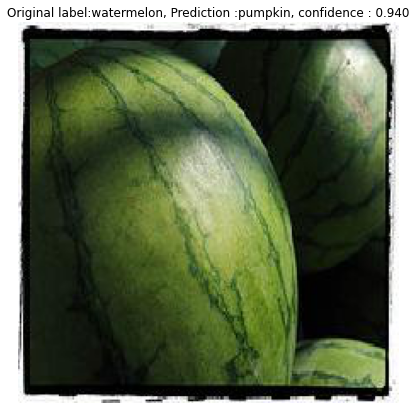

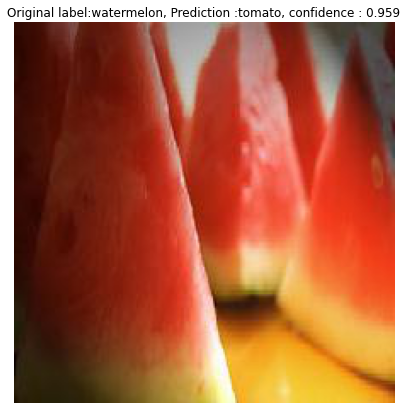

In [17]:
# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)

# Run the function to get the list of classes and errors
idx2label, errors, fnames = obtain_errors(validation_generator, predictions)

# Run the function to illustrate the error cases
show_errors(idx2label, errors, predictions, fnames)

## Experiment 3: Train last 4 layers with data augmentation 

<h3>1. Freezing all layers</h3>

Create the model setting include_top parameter to False in order to exclude the fully-connected layers at the top of the network.

In [18]:
#Load the VGG model
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x1483684c0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x148368fa0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x148faed00> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x148368e20> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x148348d60> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x14836cee0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x148348b50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x14834cb20> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x14837b910> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x148365220> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x148365f70> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x148470c10> False
<tensorflow.py

<h3>2. Prepare the training and validation data</h3>

In [19]:
# generate batches of train transformed images and labels
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 50
val_batchsize = 10

# Data generator for training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data generator for validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


<h3>3. Visualizing the datasets</h3>

The shape of train images: (224, 224, 3)


Text(0.5, 1.0, 'Train class name: pumpkin')

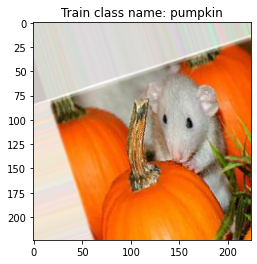

In [20]:
# Choose the image index for the visualization
image_id = 5

# Get the train image shape 
print("The shape of train images: {}".format(train_generator[image_id][0][0].shape))

# Visualize the train image example
plt.imshow(train_generator[image_id][0][0])

# Show the train image class
plt.title("Train class name: {}".format(get_class_name(train_generator, image_id)))

<h3>4. Train the model. Here we will be using the imageDataGenerator for data augmentation</h3>

Epoch 1/40
12/12 [==============================] - 74s 6s/step - loss: 1.4893 - acc: 0.3750 - val_loss: 0.7589 - val_acc: 0.7000
Epoch 2/40
12/12 [==============================] - 74s 6s/step - loss: 0.8835 - acc: 0.5950 - val_loss: 0.9336 - val_acc: 0.5667
Epoch 3/40
12/12 [==============================] - 73s 6s/step - loss: 0.5757 - acc: 0.7683 - val_loss: 0.2041 - val_acc: 0.9467
Epoch 4/40
12/12 [==============================] - 73s 6s/step - loss: 0.3520 - acc: 0.8683 - val_loss: 0.6804 - val_acc: 0.7733
Epoch 5/40
12/12 [==============================] - 73s 6s/step - loss: 0.2147 - acc: 0.9267 - val_loss: 0.2451 - val_acc: 0.9533
Epoch 6/40
12/12 [==============================] - 74s 6s/step - loss: 0.2691 - acc: 0.9017 - val_loss: 0.1528 - val_acc: 0.9467
Epoch 7/40
12/12 [==============================] - 73s 6s/step - loss: 0.2698 - acc: 0.9200 - val_loss: 0.1480 - val_acc: 0.9533
Epoch 8/40
12/12 [==============================] - 73s 6s/step - loss: 0.0723 - acc: 0.98

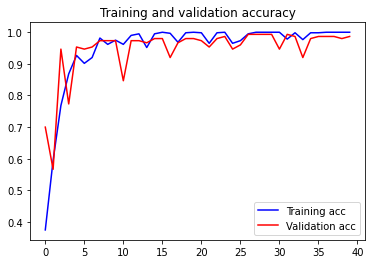

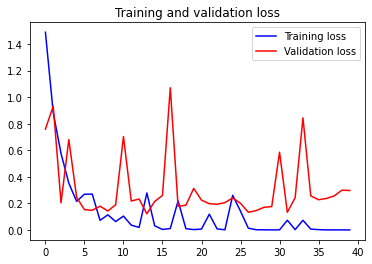

In [21]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the model
model.save('da_last4_layers.h5')

# Run the function to illustrate accuracy and loss
visualize_results(history)

<h3>5. Show the errors</h3>

15/15 [==============================] - 12s 829ms/step
The list of classes:  ['pumpkin', 'tomato', 'watermelon']
Number of errors = 2/150


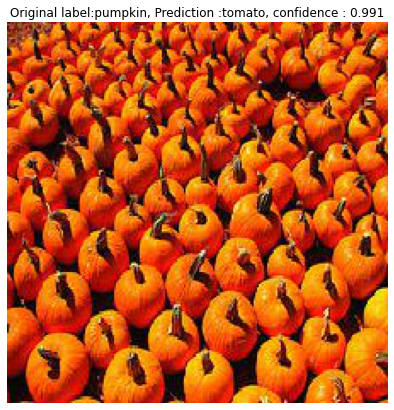

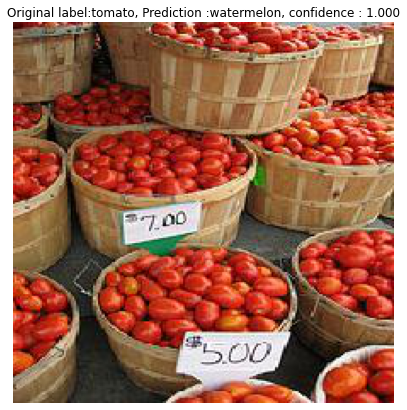

In [22]:
# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)

# Run the function to get the list of classes and errors
idx2label, errors, fnames = obtain_errors(validation_generator, predictions)

# Run the function to illustrate the error cases
show_errors(idx2label, errors, predictions, fnames)